# Imports

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import librosa
import librosa.display
import os
import numpy as np
import csv
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
from torchvision import datasets
from math import floor

# Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/APS360Project/GTZAN"

Mounted at /content/drive/


# Data Processing

Mel-Spectrogram Generation


In [ ]:
%matplotlib agg

audio_path =  path + "/genres_original/"
MFCC_path =  path + "/MFCC_imgs/"
num_genres = 0

if not os.path.isdir(MFCC_path):
  os.mkdir(MFCC_path)

for genre in os.listdir(audio_path):
  num_genres += 1

  if not os.path.isdir(MFCC_path + genre):
    os.mkdir(MFCC_path + genre)

  for audio_clip in os.listdir(audio_path + genre):
    curr_audio_path = audio_path + genre + '/' + audio_clip

    y, sr = librosa.load(curr_audio_path)
    S = librosa.feature.melspectrogram(y, sr=sr)
    S_DB = librosa.amplitude_to_db(S, ref=np.max)

    librosa.display.specshow(S_DB, sr=sr, hop_length=512,)

    plt.savefig(MFCC_path + genre + '/' + audio_clip.split('.')[0] +
                audio_clip.split('.')[1] + '.png')

Mel-Spectrogram Generation for 3 second splits \
Ran locally to save drive space

In [ ]:

audio_path = path + "/genres_original/"
MFCC_path = path + "/MFCC_imgs/"

# Assign directory for the split MFCC files. The folder path should be added manually.
split_MFCC_path = path + "/MFCC_imgs_split/"

num_genres = 0

if not os.path.isdir(MFCC_path):
    os.mkdir(MFCC_path)

for genre in os.listdir(audio_path):
    num_genres += 1

    if not os.path.isdir(MFCC_path + genre):
        os.mkdir(MFCC_path + genre)

    for audio_clip in os.listdir(audio_path + genre):
        curr_audio_path = audio_path + genre + '/' + audio_clip

        y, sr = librosa.load(curr_audio_path)

        for count in range(10):
            split_y = y[sr * 3 * count: (sr * 3 * (count + 1)) - 1]
            S = librosa.feature.melspectrogram(y=split_y, sr=sr)
            S_DB = librosa.amplitude_to_db(S, ref=np.max)
            librosa.display.specshow(S_DB, sr=sr, hop_length=512, )


            plt.savefig(split_MFCC_path + genre + '/' + audio_clip.split('.')[0]
                        + audio_clip.split('.')[1] + '.' + str(count) + '.png')

30 Second Clip Feature Extraction

In [ ]:
audio_path =  path + "/genres_original/"

header = 'filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean \
    spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var \
    rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var \
    harmony_mean harmony_var perceptr_mean perceptr_var tempo'

for i in range(1, 21):
    header += f' mfcc{i}_mean'
    header += f' mfcc{i}_var'

header += ' label'
header = header.split()


file = open(path + 'features_30_sec.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

for genre in os.listdir(audio_path):
  for audio_clip in os.listdir(audio_path + genre):

        curr_audio_path = audio_path + genre + '/' + audio_clip
        y, sr = librosa.load(curr_audio_path, mono=True, duration=30)
        length = librosa.get_duration(y=y, sr=sr) * sr
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        harm, perc = librosa.effects.hpss(y)
        tempo = librosa.beat.tempo(y=y, sr=sr)

        to_append = f'{audio_clip} {length} {np.mean(chroma_stft)} {np.var(chroma_stft)} \
        {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} \
         {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} \
         {np.mean(zcr)} {np.var(zcr)} {np.mean(harm)} {np.var(harm)} \
         {np.mean(perc)} {np.var(perc)} {np.mean(tempo)}'

        for e in mfcc:
            to_append += f' {np.mean(e)}'
            to_append += f' {np.var(e)}'

        to_append += f' {genre}'

        file = open(path + 'features_30_sec.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


3 Second Clip Splitting and Feature Extraction \
Ran locally to save drive space

In [ ]:
audio_path = path + "/genres_original/"
new_audio_path = path + "/genres_split/"


header = 'filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean \
    spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var \
    rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var \
    harmony_mean harmony_var perceptr_mean perceptr_var tempo'

for i in range(1, 21):
    header += f' mfcc{i}_mean'
    header += f' mfcc{i}_var'

header += ' label'
header = header.split()

# Updated name to be 'features_10_sec.csv'
file = open('features_10_sec.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)


for genre in os.listdir(audio_path):
    for audio_clip in os.listdir(audio_path + genre):
        curr_audio_path = audio_path + genre + '/' + audio_clip
        x, sr = librosa.load(curr_audio_path, mono=True, duration=30)

        # Split the audio file into 10s intervals and rename it and make features for the split files.
        file_num = 0
        for i in range(0, len(x), 3 * sr):
            y = x[i: (3 * sr) + i]
            update_filename = audio_clip[:-3] + str(file_num) + ".wav"
            update_audio_path = new_audio_path + genre + '/' + update_filename

            # Write the new audio to update_audio_path directory.
            # Will need to manually make the folder path for each genres.
            sf.write(update_audio_path, y, sr)
            file_num += 1

            # Moved all the feature extraction codes inside the audio split for-loop.
            length = librosa.get_duration(y=y, sr=sr) * sr
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rms = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            harm, perc = librosa.effects.hpss(y)
            tempo = librosa.beat.tempo(y=y, sr=sr)

            # Update: changed the file name to be "update_curr_audio_path"
            to_append = f'{update_filename} {length} {np.mean(chroma_stft)} {np.var(chroma_stft)} \
            {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} \
             {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} \
             {np.mean(zcr)} {np.var(zcr)} {np.mean(harm)} {np.var(harm)} \
             {np.mean(perc)} {np.var(perc)} {np.mean(tempo)}'

            for e in mfcc:
                to_append += f' {np.mean(e)}'
                to_append += f' {np.var(e)}'

            to_append += f' {genre}'

            file = open('features_10_sec.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

# Baseline Model Section

## Subsection 1. 3 second model


In [ ]:
## Code for Baseline Model will go here

In [ ]:
knn_path = path + "/features_3_sec.csv"
knn_data = pd.read_csv(knn_path)
knn_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66150,0.335555,0.090997,0.130189,0.003559,1773.358004,169450.82950,1972.334258,117272.64020,...,39.547073,-3.230046,36.606857,0.696385,37.766129,-5.035945,33.668549,-0.239585,43.818882,blues
1,blues.00000.1.wav,66150,0.343523,0.086782,0.112119,0.001491,1817.244034,90766.29725,2010.751494,65940.66624,...,64.819778,-6.025472,40.548805,0.127131,51.048939,-2.808956,97.221489,5.771882,60.360352,blues
2,blues.00000.2.wav,66150,0.347746,0.092495,0.130895,0.004552,1790.722357,110071.20700,2088.184750,73391.49800,...,68.306793,-1.714475,28.136948,2.329553,47.211426,-1.925621,52.922432,2.466996,33.164001,blues
3,blues.00000.3.wav,66150,0.363863,0.087207,0.131349,0.002338,1660.545231,109496.93630,1967.920582,79805.90135,...,48.543201,-3.786986,28.419544,1.153315,35.682701,-3.501979,50.610340,3.580636,32.325874,blues
4,blues.00000.4.wav,66150,0.335481,0.088482,0.142370,0.001734,1634.465077,77425.41923,1954.633566,57359.69560,...,30.829542,0.635797,44.645561,1.591108,51.415859,-3.364909,26.421085,0.501505,29.109531,blues


In [ ]:
knn_data = knn_data.iloc[0:, 1:]
knn_y = knn_data["label"]
knn_x = knn_data.loc[:, knn_data.columns != 'label']

# Normalize X
xcols = knn_x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(knn_x)

knn_x = pd.DataFrame(np_scaled, columns = xcols)

In [ ]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_x, knn_y, test_size=0.2, random_state=32, shuffle=True)

In [ ]:
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(knn_X_train, knn_y_train)
y_pred_10 = knn_10.predict(knn_X_test)
print('Accuracy of KNN model for 3 seconds interval dataset, with 10 neighbours: ', round(accuracy_score(knn_y_test, y_pred_10), 5))

Accuracy of KNN model for 3 seconds interval dataset, with 10 neighbours:  0.868


In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(knn_X_train, knn_y_train)
y_pred = knn.predict(knn_X_test)
print('Accuracy of KNN model for 3 seconds interval dataset, with 20 neighbours: ', round(accuracy_score(knn_y_test, y_pred), 5))

Accuracy of KNN model for 3 seconds interval dataset, with 20 neighbours:  0.8105


In [ ]:
knn_all = KNeighborsClassifier(n_neighbors=100)
knn_all.fit(knn_X_train, knn_y_train)
y_pred_all = knn_all.predict(knn_X_test)
print('Accuracy of KNN model for 3 seconds interval dataset, with all neighbours: ', round(accuracy_score(knn_y_test, y_pred_all), 5))

Accuracy of KNN model for 3 seconds interval dataset, with all neighbours:  0.692


## Subsection 2. 30 Second Model

In [ ]:
knn_30_path = path + "/features_30_sec.csv"
knn_30_data = pd.read_csv(knn_30_path)
knn_30_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,jazz.00000.wav,661500.0,0.344568,0.085005,0.046768,0.001543,1504.404759,554635.808130,1754.409592,283727.376842,...,50.317745,-1.502332,41.169983,0.221480,55.749470,-1.991628,50.034637,-3.348313,49.907917,jazz
1,jazz.00003.wav,661500.0,0.319313,0.081005,0.059496,0.001298,813.293729,92950.399709,1058.898921,220025.916341,...,47.350842,-2.272845,54.629692,3.883317,38.872822,0.344252,50.070782,-2.214156,56.304241,jazz
2,jazz.00002.wav,661500.0,0.267640,0.083949,0.080840,0.000992,1064.810564,161183.061715,1050.419172,62157.266400,...,39.972137,-12.295748,54.781208,-6.769270,45.765415,-3.495534,41.461681,-8.644752,73.453781,jazz
3,jazz.00005.wav,661500.0,0.248236,0.096418,0.107555,0.002236,1268.061497,286543.046719,1546.300122,236694.493580,...,229.317825,0.863595,405.584015,0.953356,332.244568,1.736951,193.131317,-1.345491,212.923080,jazz
4,jazz.00004.wav,661500.0,0.171782,0.082596,0.108786,0.002178,1039.623420,122521.889902,1422.303098,77324.475593,...,162.859573,1.991310,181.093201,4.985074,162.339539,6.582728,393.453186,-2.426803,473.187347,jazz


In [ ]:
len(knn_30_data)

1000

In [ ]:
knn_30_data = knn_30_data.iloc[0:, 1:]
knn_30_y = knn_30_data["label"]
knn_30_x = knn_30_data.loc[:, knn_30_data.columns != 'label']

# Normalize X
x30cols = knn_30_x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(knn_30_x)

knn_30_x = pd.DataFrame(np_scaled, columns = x30cols)

In [ ]:
knn30_X_train, knn30_X_test, knn30_y_train, knn30_y_test = train_test_split(knn_30_x, knn_30_y, test_size=0.3, random_state=42)

In [ ]:
knn30_5 = KNeighborsClassifier(n_neighbors=10)
knn30_5.fit(knn30_X_train, knn30_y_train)
y30_5_pred = knn30_5.predict(knn30_X_test)
print('Accuracy of KNN model with 30 seconds interval dataset, 5 nearest neighbours: ', round(accuracy_score(knn30_y_test, y30_5_pred), 5))

Accuracy of KNN model with 30 seconds interval dataset, 5 nearest neighbours:  0.62667


In [ ]:
knn30 = KNeighborsClassifier(n_neighbors=20)
knn30.fit(knn30_X_train, knn30_y_train)
y30_pred = knn30.predict(knn30_X_test)
print('Accuracy of KNN model: ', round(accuracy_score(knn30_y_test, y30_pred), 5))

Accuracy of KNN model:  0.57333


In [ ]:
knn30_ALL = KNeighborsClassifier(n_neighbors=100)
knn30_ALL.fit(knn30_X_train, knn30_y_train)
y30_ALL_pred = knn30_ALL.predict(knn30_X_test)
print('Accuracy of KNN model: ', round(accuracy_score(knn30_y_test, y30_ALL_pred), 5))

Accuracy of KNN model:  0.44667


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(knn_x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

pcadf = pd.concat([principalDf, knn_y], axis = 1)

pca_y = pcadf["label"]
pca_x = pcadf.loc[:, pcadf.columns != 'label']

In [ ]:
from matplotlib.colors import ListedColormap
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(pca_x, pca_y, test_size = 0.33, random_state = 41)

# init vars
n_neighbors = 5
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])

knn_pca = KNeighborsClassifier(n_neighbors=10)
knn_pca.fit(X_train, y_train)

x_min, x_max = pca_x.to_numpy()[:, 0].min() - 1, pca_x.to_numpy()[:, 0].max() + 1
y_min, y_max = pca_x.to_numpy()[:, 1].min() - 1, pca_x.to_numpy()[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
color_list = ListedColormap(["Accent", "Blues", "BuGn", "PiYG", "PuBuGn_r", "Purples", "RdYlBu_r", "autumn","bone", "gist_heat"])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

Z = Z.reshape(xx.shape)
fig = plt.figure()

plt.pcolormesh(xx, yy, Z, cmap = cmap_light)

# Plot also the training points, x-axis = 'Glucose', y-axis = "BMI"
# plt.scatter(pca_x.to_numpy()[:, 0], pca_x.to_numpy()[:, 1], c = color_list)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.title("0/1 outcome classification (k = %i, weights = '%s')" % (5, "Default"))
# plt.show()

In [ ]:
Z.shape

(192, 215)

# CNN Model

Data Loading & Splitting

In [ ]:
def get_data(batch_size = 32):

  mel_path = path + "/MFCC_imgs"
  transform = transforms.Compose([transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])  #convert data into a tensor, and then normalize it

  torch.manual_seed(620)

  train_set = torchvision.datasets.ImageFolder(mel_path + "/training", loader = plt.imread, transform = transform)
  valid_set = torchvision.datasets.ImageFolder(mel_path + "/valid", loader = plt.imread, transform = transform)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                               num_workers=1, shuffle=True)
  val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                               num_workers=1, shuffle=True)

  return train_loader, val_loader

Accuracy Function

In [ ]:
def get_accuracy(net, loader, use_cuda = True):
  total_accuracy = 0
  total_epoch = 0

  for imgs, labels in loader:
    output = net(imgs)
    pred = output.max(1, keepdim = True)[1]
    total_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    total_epoch += labels.shape[0]
  accuracy = float(total_accuracy) / total_epoch

  return accuracy

Initialize CNN


In [ ]:
%matplotlib inline

genre_count = 10 #num_genres

#include drop_out


class CNN(nn.Module):
  def __init__(self, c1 = {"in_ch":4,"out_ch":8,"k":3, "str":1,"pad":0}, c2 = {"in_ch":8,"out_ch":16,"k":3,"str":1,"pad":0},
               c3 =  {"in_ch":16,"out_ch":32,"k":3,"str":1,"pad":0}, c4 =  {"in_ch":32,"out_ch":64, "k":3,"str":1,"pad":0}, hyparam_fc1 = {"size":64}, gc = genre_count, dropout = 0.25):
    torch.manual_seed(1000)
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(c1["in_ch"],c1["out_ch"],c1["k"],c1["str"],padding = c1["pad"])
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(c2["in_ch"],c2["out_ch"],c2["k"],c2["str"],padding = c2["pad"])
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(c3["in_ch"],c3["out_ch"],c3["k"],c3["str"],padding = c3["pad"])
    self.pool3 = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(c4["in_ch"],c4["out_ch"],c4["k"],c4["str"],padding = c4["pad"])

    #computing input layer size assumming 4x288x432 sized images
    self.paramsx1 = floor((288 - c1["k"] + c1["pad"])/c1["str"]) + 1  #Convolution layer 1 x output
    self.paramsx2 = floor((self.paramsx1 - 2)/2) + 1  #Pooling layer 1 x output
    self.paramsx3 = floor((self.paramsx2 - c2["k"] + c2["pad"])/c2["str"]) + 1   #Convolution layer 2 x output
    self.paramsx4 = floor((self.paramsx3 - 2)/2) + 1  #Pooling layer 2 x output
    self.paramsx5 = floor((self.paramsx4 - c3["k"] + c3["pad"])/c3["str"]) + 1   #Convolution layer 2 x output
    self.paramsx6 = floor((self.paramsx5 - 2)/2) + 1  #Pooling layer 2 x output
    self.paramsx7 = floor((self.paramsx6 - c4["k"] + c4["pad"])/c4["str"]) + 1   #Convolution layer 2 x output
    self.paramsx8 = floor((self.paramsx7 - 2)/2) + 1  #Pooling layer 2 x output
    # print("self.paramsx8 = ", self.paramsx8)

    self.paramsy1 = floor((432 - c1["k"] + c1["pad"])/c1["str"]) + 1
    self.paramsy2 = floor((self.paramsy1 - 2)/2) + 1  #Pooling layer 1 y output
    self.paramsy3 = floor((self.paramsy2 - c2["k"] + c2["pad"])/c2["str"]) + 1   #Convolution layer 2 y output
    self.paramsy4 = floor((self.paramsy3 - 2)/2) + 1  #Pooling layer 2 y output
    self.paramsy5 = floor((self.paramsy4 - c3["k"] + c3["pad"])/c3["str"]) + 1   #Convolution layer 2 x output
    self.paramsy6 = floor((self.paramsy5 - 2)/2) + 1  #Pooling layer 2 x output
    self.paramsy7 = floor((self.paramsy6 - c4["k"] + c4["pad"])/c4["str"]) + 1   #Convolution layer 2 x output
    self.paramsy8 = floor((self.paramsy7 - 2)/2) + 1  #Pooling layer 2 x output
    # print("self.paramsy8 = ", self.paramsy8)


    self.fc1 = nn.Linear(c4["out_ch"]*self.paramsx8*self.paramsy8,hyparam_fc1["size"])
    self.fc2 = nn.Linear(hyparam_fc1["size"],gc)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv3(x)))
    x = self.pool3(F.relu(self.conv4(x)))
    # print("x.shape = ", x.shape)
    # print("x.shape[1] = ", x.shape[1])
    x = x.view(-1,x.shape[1]*self.paramsx8*self.paramsy8)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)  #use nn.crossentropy loss to automatically apply signmoid activation
    return x

Training Function


In [ ]:
def train(model, lr = 0.001, epochs = 18, criterion = "CE", optimizer = "Adam", mom=0.5, batch_size = 32, weight_decay = 0):
  '''inputs: nn model, training and validation data (torch.utils.data.DataLoader class), learning rate lr, no. of epochs, loss function criterion
  outputs: trained model, accuracy plots'''
  train_data, val_data = get_data(batch_size = batch_size)
  #print("train_data = ", train_data)
  loss_dict = {"CE": nn.CrossEntropyLoss()}
  loss_f = loss_dict[criterion]

  optim_dict = {"SGD": torch.optim.SGD(model.parameters(), lr, momentum=mom, weight_decay = weight_decay),"Adam":torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)}
  opt = optim_dict[optimizer]
  #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
  eps = []
  losses = []
  train_accuracy = []
  val_accuracy = []
  patience = 0

  #train model
  start_time = time.time()
  for epoch in range(epochs):
    print("epoch = ", epoch)
    iteration = 0

    #early stop with patience
    if epoch > 1:
      if val_accuracy[epoch - 2] > val_accuracy[epoch - 1]:
        patience+=1
        print("patience = ", patience)
      if patience > 8:
        print("Error: Validation Accuracy Run-Off")
        break
      if epoch > 13 and val_accuracy[epoch - 1]<0.25:
        print("Error: Low Validation Accuracy")
        break


    for (images, labels) in train_data:
      #print("batch_no. = ", iteration)
      iteration+=1
      #print("shape =", images.shape)

    #make passes
      outputs = model(images)    #make prediction; softmax applied by criterion
      loss = loss_f(outputs, labels)
      loss.backward()    #calculate gradient
      opt.step()   #update model parameters
      opt.zero_grad()   #clean up
      #optimizer.step()
      #optimizer.zero_grad()

    #record information for epoch
    eps.append(epoch)
    losses.append(float(loss)/batch_size)
    train_accuracy.append(get_accuracy(model,train_data))
    val_acc = get_accuracy(model,val_data)
    print("val acc: ", val_acc)
    val_accuracy.append(val_acc)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  print("Final Training Loss: ", losses[-1])
  print("Final Training Accuracy: ", train_accuracy[-1])
  print("Final Val Accuracy: ", val_accuracy[-1])

  #plotting
  plt.title("Training Loss vs. Epochs")
  plt.plot(eps, losses, label="Training")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Accuracy vs. Epochs")
  plt.plot(eps, train_accuracy, label="Train")
  plt.plot(eps, val_accuracy, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  return model




Training & Hyperparameter Optimization

In [ ]:
model = CNN()

try4 = train(model, epochs = 1, batch_size = 64, lr = 0.001, optimizer ="Adam")

train_data =  <torch.utils.data.dataloader.DataLoader object at 0x7efdd9af6050>
epoch =  0
val acc:  0.22
epoch =  1
val acc:  0.22
epoch =  2
val acc:  0.26666666666666666
epoch =  3
val acc:  0.32
epoch =  4
val acc:  0.37333333333333335
epoch =  5
val acc:  0.3466666666666667
epoch =  6
patience =  1
val acc:  0.38
epoch =  7
val acc:  0.38666666666666666
epoch =  8
val acc:  0.4066666666666667
epoch =  9
val acc:  0.46
epoch =  10
val acc:  0.5466666666666666
epoch =  11
val acc:  0.48
epoch =  12
patience =  2
val acc:  0.49333333333333335
epoch =  13
val acc:  0.52
epoch =  14
val acc:  0.5466666666666666
epoch =  15
val acc:  0.5533333333333333
epoch =  16
val acc:  0.56
epoch =  17
val acc:  0.5466666666666666
epoch =  18
patience =  3
val acc:  0.5466666666666666
epoch =  19
val acc:  0.5466666666666666
Total time elapsed: 1475.18 seconds
Final Training Loss:  0.010166766121983528
Final Training Accuracy:  0.7364705882352941
Final Val Accuracy:  0.5466666666666666


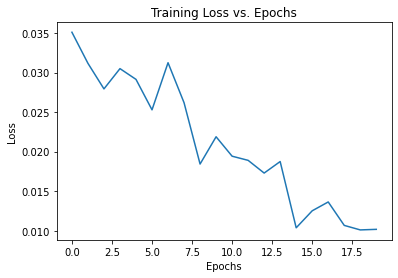

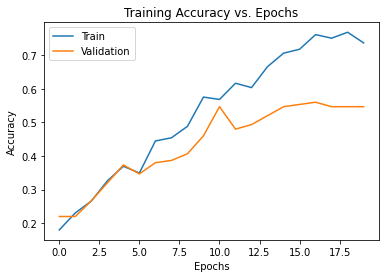

In [ ]:
model5 = CNN()

try5 = train(model5, epochs = 20, batch_size = 64, lr = 0.001, optimizer ="Adam")

train_data =  <torch.utils.data.dataloader.DataLoader object at 0x7efdd878c950>
epoch =  0
val acc:  0.23333333333333334
epoch =  1
val acc:  0.18
epoch =  2
patience =  1
val acc:  0.31333333333333335
epoch =  3
val acc:  0.2733333333333333
epoch =  4
patience =  2
val acc:  0.36
epoch =  5
val acc:  0.3466666666666667
epoch =  6
patience =  3
val acc:  0.36
epoch =  7
val acc:  0.3933333333333333
epoch =  8
val acc:  0.38666666666666666
epoch =  9
patience =  4
val acc:  0.38
epoch =  10
patience =  5
val acc:  0.37333333333333335
epoch =  11
patience =  6
val acc:  0.46
epoch =  12
val acc:  0.44666666666666666
epoch =  13
patience =  7
val acc:  0.4666666666666667
epoch =  14
val acc:  0.52
epoch =  15
val acc:  0.5666666666666667
epoch =  16
val acc:  0.5466666666666666
epoch =  17
patience =  8
val acc:  0.5333333333333333
epoch =  18
patience =  9
Error: Validation Accuracy Run-Off
Total time elapsed: 1322.87 seconds
Final Training Loss:  0.016259804368019104
Final Training Accu

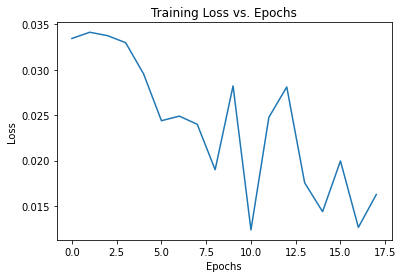

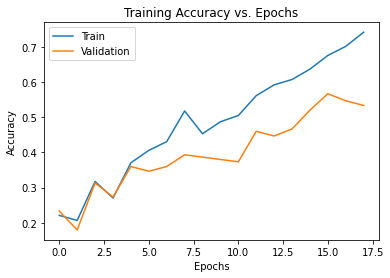

In [ ]:
model6 = CNN()

try6 = train(model6, epochs = 20, batch_size = 64, lr = 0.001, optimizer ="Adam", weight_decay = 0.001)

Qualitative Testing

In [ ]:
def qual_test(model, batch_size = 16):
  mel_path = path + "/Qual_testing"
  transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])  #convert data into a tensor, and then normalize it
  torch.manual_seed(1000)
  genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
  accuracies = []
  for genre in genres:
    print("genre = ",genre)
    v_set = torchvision.datasets.ImageFolder(mel_path + '/' + genre, loader = plt.imread, transform = transform)
    v_set_loader = torch.utils.data.DataLoader(v_set, batch_size=batch_size, num_workers=1, shuffle=True)
    accuracy = get_accuracy(model,v_set_loader)
    accuracies.append(accuracy)
    print("accuracy = ", accuracy)

  plt.title("Validation Accuracy By Genre")
  plt.scatter(genres, accuracies)
  plt.xlabel("Genres")
  plt.ylabel("Validation Accuracy")
  plt.show()

genre =  blues
accuracy =  0.4666666666666667
genre =  classical
accuracy =  0.0
genre =  country
accuracy =  0.0
genre =  disco
accuracy =  0.0
genre =  hiphop
accuracy =  0.06666666666666667
genre =  jazz
accuracy =  0.13333333333333333
genre =  metal
accuracy =  0.0
genre =  pop
accuracy =  0.0
genre =  reggae
accuracy =  0.0
genre =  rock
accuracy =  0.0


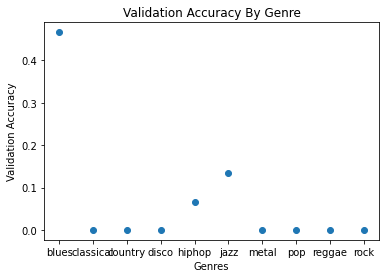

In [ ]:
batch_size = 16
mel_path = path + "/Qual_testing"
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))])  #convert data into a tensor, and then normalize it
torch.manual_seed(1000)
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
sets = []
accuracies = []

for genre in genres:
  print("genre = ",genre)
  v_set = torchvision.datasets.ImageFolder(mel_path + '/' + genre, loader = plt.imread, transform = transform)
  v_set_loader = torch.utils.data.DataLoader(v_set, batch_size=batch_size, num_workers=1, shuffle=True)
  accuracy = get_accuracy(model,v_set_loader)
  accuracies.append(accuracy)
  print("accuracy = ", accuracy)


plt.title("Validation Accuracy By Genre")
plt.scatter(genres, accuracies)
plt.xlabel("Genres")
plt.ylabel("Validation Accuracy")
plt.show()

genre =  blues
accuracy =  0.4666666666666667
genre =  classical
accuracy =  0.0
genre =  country
accuracy =  0.0
genre =  disco
accuracy =  0.0
genre =  hiphop
accuracy =  0.06666666666666667
genre =  jazz
accuracy =  0.13333333333333333
genre =  metal
accuracy =  0.0
genre =  pop
accuracy =  0.0
genre =  reggae
accuracy =  0.0
genre =  rock
accuracy =  0.0


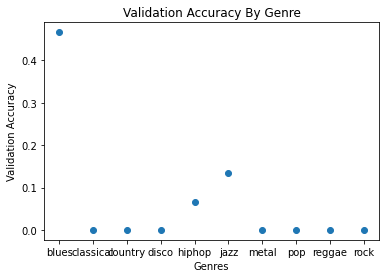

In [ ]:
qual_test(try6)

# Transformer

In [ ]:
def patchify(images, n_x_patches, n_y_patches):
  n, c, w, h = images.shape

  ps_x = w//n_x_patches   #patch size in x
  ps_y = h//n_y_patches   #patch size in y

  patches = torch.zeros(n, n_x_patches*n_y_patches, c*ps_x*ps_y)



  idx = 0
  for image in images:

    for i in range(n_x_patches):
      for j in range(n_y_patches):
        patch = image[:, i*ps_x:(i+1)*ps_x, j*ps_y:(j+1)*ps_y]

        patches[idx,i * n_y_patches + j] = patch.flatten()

    idx+=1

  return patches   #3d Tensor of N images containing n_x x n_y patches next to each other. Each patch has c x patch_size_x x patch_size_y dimensions.


In [ ]:
def get_positional_embeddings(seq_len,d):    #always rectangular
  embeddings = torch.zeros(seq_len,d)

  for i in range(seq_len):
    for j in range(d):
      if j%2 == 0:
        embeddings[i][j] = np.sin(i/(10000**(j/d)))

      else:
        embeddings[i][j] = np.cos(i/10000**((j-1)/d))

  return embeddings

In [ ]:
class Encoder(nn.Module):
  torch.manual_seed(620)
  def __init__(self, input_size = 100, hidden_size = 100, num_heads = 4):   #Num_heads = num_patches
    super(Encoder,self).__init__()
    self.linear_q = nn.Linear(input_size, hidden_size)
    self.linear_k = nn.Linear(input_size, hidden_size)
    self.linear_v = nn.Linear(input_size, hidden_size)
    self.linear_x = nn.Linear(input_size, hidden_size)
    self.attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first = True)   #Batch_first ensures the same dimensions as the patchified tensor.

    self.ff = nn.Sequential(nn.Linear(hidden_size, hidden_size),nn.ReLU(),nn.Linear(hidden_size,hidden_size)) #feed forward neural network in encoder

    self.norm = nn.LayerNorm(hidden_size)


  def forward(self, x): #x is image vector in this case?
    q, k, v = self.linear_q(x),self.linear_k(x),self.linear_v(x)  #get q, k and v layers for x
    x = self.norm(self.linear_x(x) + self.attention(q,k,v)[0]) #residual connection. MhA gives tuple: (attn_output, attn_output_weights)
    x = self.norm(x + self.ff(x))

    return x


In [ ]:
##When you call this class, please change:
#1) c,w,h to reflect the right image dimensions
#2) n_x_patches and n_y_patches to ensure w//n_x_patches == h//n_y_patches
#3) num_classes to reflect the appropriate # of genres for the datatset

%matplotlib inline

class Transformer(nn.Module):
  torch.manual_seed(620)
  def __init__(self, num_class = 10, num_blocks = 2, n_x_patches = 24,
               n_y_patches = 36, c = 4, w = 288, h = 432, d = 64, dropout = 0.25):   #num_class = genre_count; d = hidden size

    super(Transformer, self).__init__()

    #define parameters for forward method
    self.n_x_patches = n_x_patches
    self.n_y_patches = n_y_patches
    self.num_blocks = num_blocks

    #linear projection of each token to a flattened vectors
    self.linear_x = nn.Linear(c*w//n_x_patches*h//n_y_patches, d)

    #create classification token
    self.class_token = nn.Parameter(torch.rand(1, d))

    #get positional embeddings spanning all token positions
    self.pos = get_positional_embeddings(n_x_patches*n_y_patches + 1,d)   #+1 for classification token

    #encoder
    self.encoder = Encoder(d, d)

    #dropout layer
    self.dropout = nn.Dropout(dropout)

    #classficiation layer
    self.fc = nn.Linear(d, num_class)



  def forward(self, x):  #x is batch of N images
    n,c,w,h = x.shape

    #construct patches
    patches = patchify(x, self.n_x_patches, self.n_y_patches)  #N x (n_x_patches x n_y_patches)

    #Obtain linear projections for all tokens of N images
    toks = self.linear_x(patches)

    #Add classification token
    tokens = torch.stack([torch.vstack((self.class_token, toks[i])) for i in range(len(toks))]) #Make classification token come first in all N images

    #Expand positional embeddings to match N images
    pos = self.pos.repeat(n,1,1)
    output = tokens + pos

    for i in range(self.num_blocks):
      output = self.encoder(output)

    #Get classification token only
    final_out = output[:,0]

    #Dropout layer
    final_out = self.dropout(final_out)

    #pass to classification FC NN
    return self.fc(final_out)

In [ ]:
##Please make sure get_data function redirects to the right dataset that you want to use

def ttrain(model, lr = 0.001, epochs = 20, criterion = "CE", optimizer = "Adam", mom=0.5, batch_size = 32, weight_decay = 0.001):

  '''inputs: nn model, training and validation data (torch.utils.data.DataLoader class), learning rate lr, no. of epochs, loss function criterion
  outputs: trained model, accuracy plots'''

  train_data, val_data = get_data(batch_size) #Please make sure get_data function redirects to the right dataset that you want to use
  loss_dict = {"CE": nn.CrossEntropyLoss()}
  loss_f = loss_dict[criterion]

  optim_dict = {"SGD": torch.optim.SGD(model.parameters(), lr, momentum=mom, weight_decay = weight_decay),"Adam":torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)}
  opt = optim_dict[optimizer]

  eps = []
  losses = []
  train_accuracy = []
  val_accuracy = []
  patience = 0

  #train model
  start_time = time.time()
  for epoch in range(epochs):
    print("epoch = ", epoch)
    iteration = 0

    #early stop with patience
    if epoch > 1:
      if val_accuracy[epoch - 2] > val_accuracy[epoch - 1]:
        patience+=1
        print("patience = ", patience)
      if patience > 12:
        print("Error: Validation Accuracy Run-Off")
        break
      #if epoch > 13 and val_accuracy[epoch - 1]<0.5:
        #print("Error: Low Validation Accuracy")
        #break

      if val_accuracy[epoch - 1] > 0.91:
        break


    for (images, labels) in train_data:
      #print("batch_no. = ", iteration)
      #iteration+=1
      #print("shape =", images.shape)

    #make passes
      outputs = model(images)    #make prediction; softmax applied by criterion
      loss = loss_f(outputs, labels)
      loss.backward()    #calculate gradient
      opt.step()   #update model parameters
      opt.zero_grad()   #clean up

    #record information for epoch
    eps.append(epoch)
    losses.append(float(loss)/batch_size)
    train_accuracy.append(get_accuracy(model,train_data))
    val_acc = get_accuracy(model,val_data)
    print("val acc: ", val_acc)
    val_accuracy.append(val_acc)

  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  print("Final Training Loss: ", losses[-1])
  print("Final Training Accuracy: ", train_accuracy[-1])
  print("Final Val Accuracy: ", val_accuracy[-1])

  #plotting
  plt.title("Training Loss vs. Epochs")
  plt.plot(eps, losses, label="Training")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracy vs. Epochs")
  plt.plot(eps, train_accuracy, label="Train")
  plt.plot(eps, val_accuracy, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  return model

Transformer Training

In [ ]:
tmodel1 = Transformer(num_class = 8, num_blocks = 3, n_x_patches = 24,
               n_y_patches = 32, c = 4, w = 480, h = 640, d = 64, dropout = 0)
ttry_1 = ttrain(tmodel1, weight_decay = 0.001)

epoch =  0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device,f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device:  cuda (Tesla T4)


epoch =  0
val acc:  0.1
epoch =  1
val acc:  0.18666666666666668
epoch =  2
val acc:  0.16666666666666666
epoch =  3
patience =  1
val acc:  0.16
epoch =  4
patience =  2
val acc:  0.18
epoch =  5
val acc:  0.20666666666666667
epoch =  6
val acc:  0.26
epoch =  7
val acc:  0.22666666666666666
epoch =  8
patience =  3
val acc:  0.24
epoch =  9
val acc:  0.18666666666666668
epoch =  10
patience =  4
val acc:  0.24
epoch =  11
val acc:  0.18666666666666668
epoch =  12
patience =  5
val acc:  0.25333333333333335
epoch =  13
val acc:  0.22666666666666666
epoch =  14
patience =  6
Error: Low Validation Accuracy
Total time elapsed: 5388.10 seconds
Final Training Loss:  0.05907721817493439
Final Training Accuracy:  0.2235294117647059
Final Val Accuracy:  0.22666666666666666


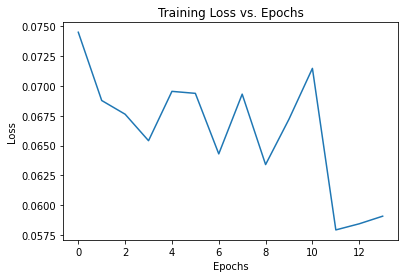

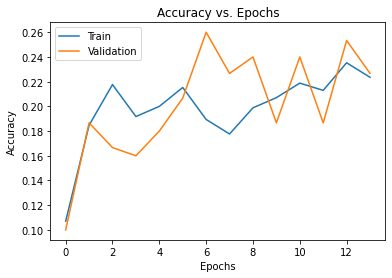

In [ ]:
tmodel2 = Transformer(num_class = 10, num_blocks = 6, c = 4, dropout = 0.25)
ttry_2 = ttrain(tmodel2, weight_decay = 0.001)

epoch =  0
val acc:  0.18
epoch =  1
val acc:  0.18666666666666668
epoch =  2
val acc:  0.17333333333333334
epoch =  3
patience =  1
val acc:  0.26666666666666666
epoch =  4
val acc:  0.20666666666666667
epoch =  5
patience =  2
val acc:  0.19333333333333333
epoch =  6
patience =  3
val acc:  0.2
epoch =  7
val acc:  0.23333333333333334
epoch =  8
val acc:  0.22
epoch =  9
patience =  4
val acc:  0.29333333333333333
epoch =  10
val acc:  0.18666666666666668
epoch =  11
patience =  5
val acc:  0.2733333333333333
epoch =  12
val acc:  0.20666666666666667
epoch =  13
patience =  6
val acc:  0.26666666666666666
epoch =  14
val acc:  0.21333333333333335
epoch =  15
patience =  7
val acc:  0.3333333333333333
epoch =  16
val acc:  0.2733333333333333
epoch =  17
patience =  8
val acc:  0.24
epoch =  18
patience =  9
val acc:  0.29333333333333333
epoch =  19
val acc:  0.23333333333333334
Total time elapsed: 4250.14 seconds
Final Training Loss:  0.057790789753198624
Final Training Accuracy:  0.2

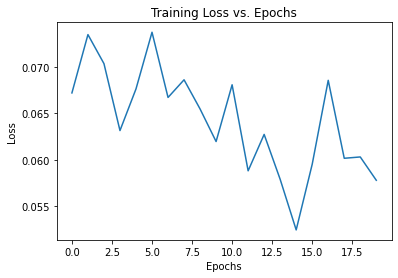

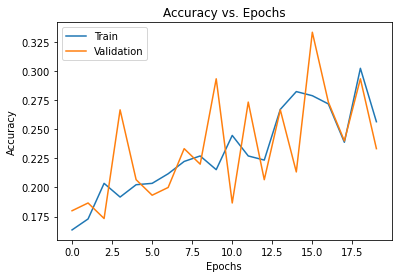

In [ ]:
tmodel2 = Transformer(num_class = 10, num_blocks = 3, dropout = 0.2)
ttry_2 = ttrain(tmodel2, weight_decay = 0.001)

epoch =  0
val acc:  0.14
epoch =  1
val acc:  0.19333333333333333
epoch =  2
val acc:  0.2
epoch =  3
val acc:  0.21333333333333335
epoch =  4
val acc:  0.17333333333333334
epoch =  5
patience =  1
val acc:  0.24
epoch =  6
val acc:  0.19333333333333333
epoch =  7
patience =  2
val acc:  0.28
epoch =  8
val acc:  0.22666666666666666
epoch =  9
patience =  3
val acc:  0.22
epoch =  10
patience =  4
val acc:  0.24666666666666667
epoch =  11
val acc:  0.22
epoch =  12
patience =  5
val acc:  0.2733333333333333
epoch =  13
val acc:  0.20666666666666667
epoch =  14
patience =  6
Error: Low Validation Accuracy
Total time elapsed: 3550.39 seconds
Final Training Loss:  0.06233758479356766
Final Training Accuracy:  0.22941176470588234
Final Val Accuracy:  0.20666666666666667


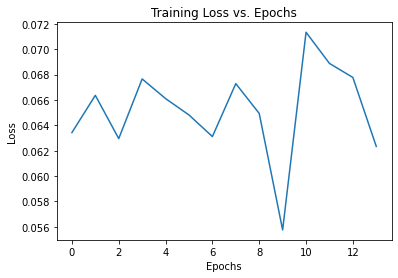

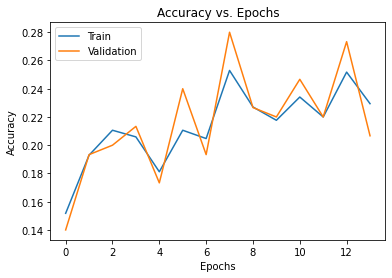

In [ ]:
tmodel3 = Transformer(num_class = 10, num_blocks = 3, c = 4, dropout = 0)
ttry_3 = ttrain(tmodel3, lr = 0.0005, weight_decay = 0.001)